# Redes LSTM


#  Predicción del valor de una acción.

## Autor

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 



## References

1. [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
2. Ralf C. Staudemeyer and Eric Rothstein Morris,[*Understanding LSTM a tutorial into Long Short-Term Memory Recurrent Neural Networks*](https://arxiv.org/pdf/1909.09586.pdf), arxiv, September 2019
3. Karpathy, [*The Unreasonable Effectiveness of Recurrent Neural Networks*](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
4. Anton Lucanus, [Making Automation More Efficient by Learning from Historical Trade Data](https://datafloq.com/read/making-automation-more-efficient-by-learning-from-/7444), 8:43 AM, January 7, 2020
5. https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/
6. https://www.youtube.com/watch?v=2BrpKpWwT2A&list=PLQVvvaa0QuDcOdF96TBtRtuQksErCEBYZ&index=1
7. https://towardsdatascience.com/using-lstms-for-stock-market-predictions-tensorflow-9e83999d4653
8. https://github.com/llSourcell/Reinforcement_Learning_for_Stock_Prediction/blob/master/README.md


# Importar las librería requeridas

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Versión de Tensorflow: ", tf.__version__)

Versión de Tensorflow:  2.1.0


In [3]:
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#importing required libraries
from sklearn.preprocessing import MinMaxScaler
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, LSTM

# Funciones utilitarias

In [4]:
# Funciones auxiliares
#
def plot_prediction(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

#

# Lectura de  los datos

Estos datos corresponden a la empresa *Tata Global Beverages*. Son  1235 datos que corresponden a observaciones del precio de la acción, el número de transacciones de la acción (compra-venta). Los datos son diarios (dias hábiles o comerciales). Están entre el 8 de octubre de 2013 hasta el 8 de octubre de 2018.

la columna *Date* es la fecha, *Open* es el valor de acción a la apertura del mercado, *High* el valor más alto alcanzado en el día, *Low* el valor más bajo del día, *Close* el valor al cierre, *Total_Trade_Quantity* el total de acciones transadas y *Turnover_Lacs* rotación.

In [5]:

#reading from a local file
df = pd.read_csv('./Datos/AAPL_2006-01-01_to_2018-01-01.csv')


In [6]:
# looking at the first five rows of the data
print('\n Shape of the data:')
print(df.shape)
df.head()


 Shape of the data:
(3019, 7)


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


Vamos a cambiar el índice de los datos. Tomaremos la fecha como indice: *df.index*. Los datos se reordenan para inveetir la tabla, debido a que los datos contienen los datos más recientes en la parte superior de la tabla.

# Extrae datos para la serie que se desea predecir (Close)

In [10]:
#creating dataframe with date and the target variable

df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
df = df.sort_index(ascending=True, axis=0)
data = pd.DataFrame(df[['Date', 'Close']])
#
#setting index
data.index = data.Date
data.drop('Date', axis=1, inplace=True)
data.head()

,Close
Date,
2006-01-03,10.68
2006-01-04,10.71
2006-01-05,10.63
2006-01-06,10.90
2006-01-09,10.86


# Visualización de la serie precio al cierre (Close)


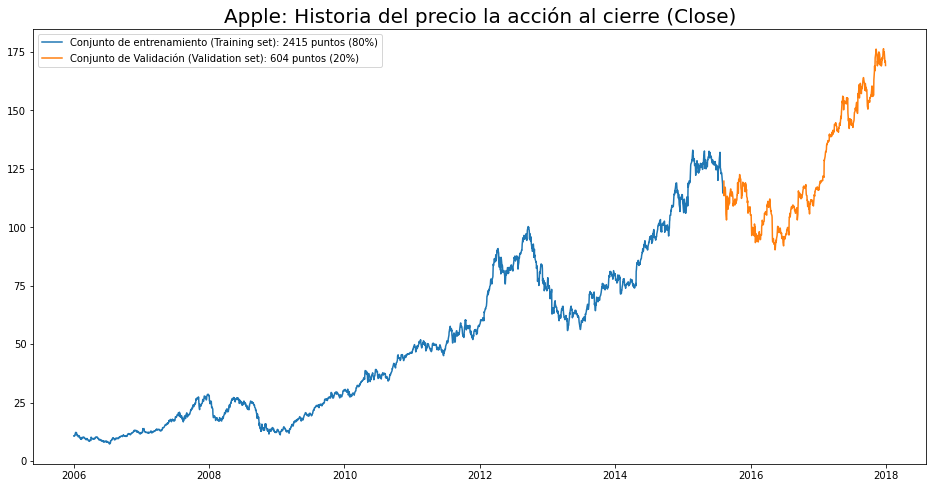

In [14]:
# plot
plt.figure(figsize=(16,8))
plt.plot(data[:2415], label='Conjunto de entrenamiento (Training set): 2415 puntos (80%)')
plt.plot(data['Close'][2415:], label='Conjunto de Validación (Validation set): 604 puntos (20%)') #604 data
plt.title("Apple: Historia del precio la acción al cierre (Close)", size = 20)
plt.legend()
plt.show()

# Preparación de los datos para el entrenamiento de la red LSTM

Para evitar problemas con las tendencias y para mejorar la estimación (entrenamiento) los datos se van a transformar a la escala $[0,1]$. Para las predicciones se utiliza la transformación inversa.



## Primero extrae los valores y se crea el  objeto MinMaxScaler

In [15]:
#creating train and test sets
dataset = data.values

# create the scaler object and scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

##  Crea datos de entrenamiento 
 La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
 partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 60

In [17]:
len_train = 2415
len_valid = 604
len_data = len_train + len_valid
time_step = 60

x_train, y_train = [], []
for i in range(time_step ,len_train ):
    # x: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    x_train.append(scaled_data[i-time_step :i,0])
    # y: el siguiente dato
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape


(2355, 60, 1)

#  Crea la red LSTM

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=time_step, return_sequences=True, input_shape=(x_train.shape[1],1)),
    tf.keras.layers.LSTM(units=time_step),
    tf.keras.layers.Dense(1)])


#  Compila el modelo

Se usará el optimizador Adam y la función de pérdida MSE

In [19]:
model.compile(loss='mse', optimizer='adam')

# Entrena el modelo


In [20]:
model.fit(x_train,y_train,epochs=20,batch_size=32)

Train on 2355 samples
Epoch 1/20
2355/2355 [==============================] - 14s 6ms/sample - loss: 0.0053
Epoch 2/20
2355/2355 [==============================] - 8s 3ms/sample - loss: 2.2522e-04
Epoch 3/20
2355/2355 [==============================] - 8s 3ms/sample - loss: 2.1806e-04
Epoch 4/20
2355/2355 [==============================] - 8s 4ms/sample - loss: 2.0777e-04
Epoch 5/20
2355/2355 [==============================] - 8s 4ms/sample - loss: 2.1153e-04
Epoch 6/20
2355/2355 [==============================] - 8s 4ms/sample - loss: 2.0279e-04
Epoch 7/20
2355/2355 [==============================] - 8s 3ms/sample - loss: 2.1821e-04
Epoch 8/20
2355/2355 [==============================] - 8s 3ms/sample - loss: 1.7811e-04
Epoch 9/20
2355/2355 [==============================] - 8s 4ms/sample - loss: 1.6424e-04
Epoch 10/20
2355/2355 [==============================] - 9s 4ms/sample - loss: 1.6263e-04
Epoch 11/20
2355/2355 [==============================] - 8s 4ms/sample - loss: 1.6089e-04


# Validación: Predicciones

## Prepara los datos de validación

In [21]:
inputs = data[len_data - len_valid - time_step:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

x_test = []
for i in range(time_step,inputs.shape[0]):
    x_test.append(inputs[i-time_step:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))


In [22]:
x_test.shape

(604, 60, 1)

# Calcula predicciones

In [23]:
# predictions
prediction = model.predict(x_test)
prediction = scaler.inverse_transform(prediction)

In [24]:
prediction.shape

(604, 1)

# Gráfica de las predicciones

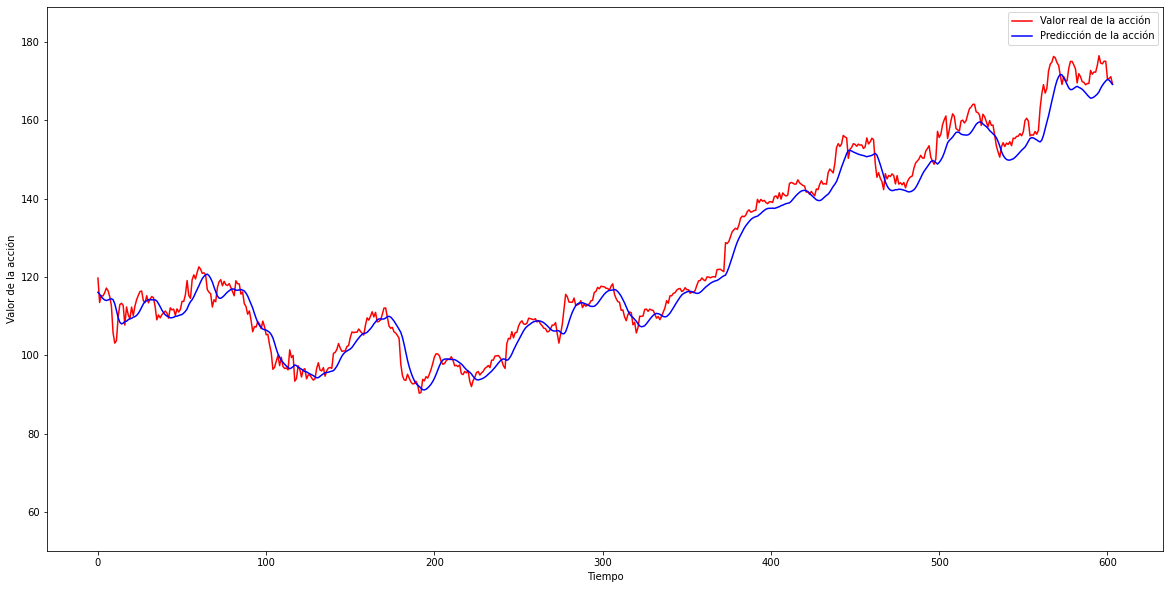

In [37]:
# Graficar resultadosdata[len_data - len_valid - time_step:].valuesdata['Close'][987:]
set_validation = data[len_data - len_valid :].values
plot_prediction(set_validation ,prediction)

In [35]:
train = pd.DataFrame(data[:len_train])
valid = pd.DataFrame(data[len_train:])
valid['Predictions'] = prediction


In [36]:
np.sqrt(np.mean(np.power(valid['Close'].values-valid['Predictions'].values,2)))
rmsLSTM = np.sqrt(np.mean(np.power(valid['Close'].values-valid['Predictions'].values,2)))
rmsLSTM 

3.575949138073724

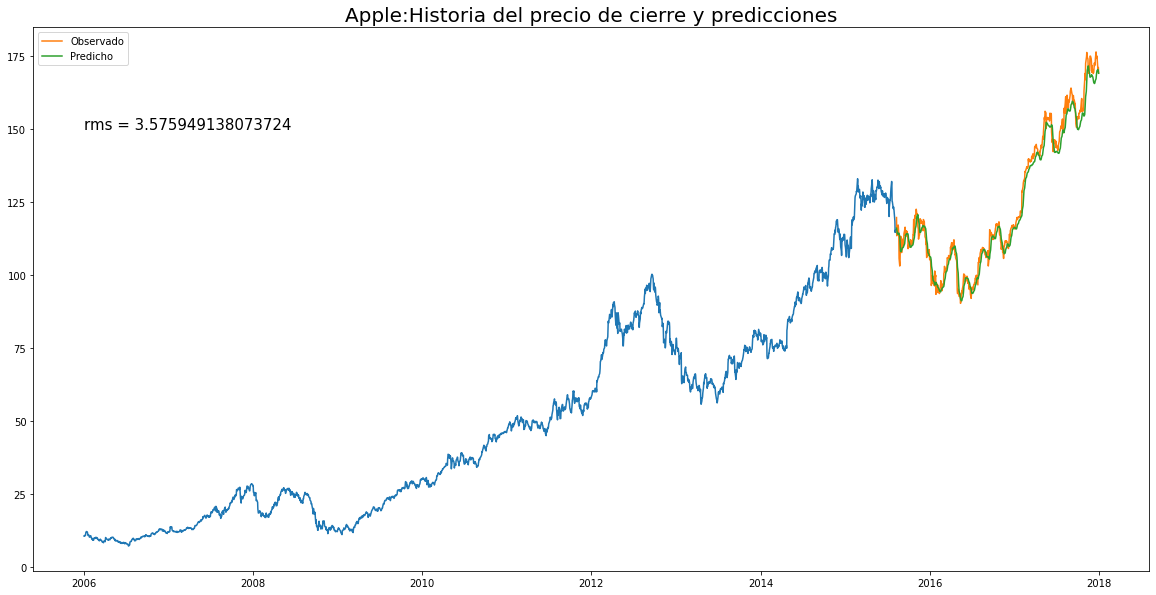

In [39]:
#for plotting
rmsLSTM = np.sqrt(np.mean(np.power(valid['Close'].values-valid['Predictions'].values,2)))

train = pd.DataFrame(data[:len_train])
valid = pd.DataFrame(data[len_train:])

valid['Predictions'] = prediction
plt.plot(train['Close'])
plot = plt.plot(valid[['Close','Predictions']])
plt.annotate("rms = "+str(rmsLSTM) , xy=(data.index[1],150), size = 15)
plt.legend(plot, ("Observado","Predicho"))
plt.title("Apple:Historia del precio de cierre y predicciones", size = 20)
plt.show()

Bibliography (links):

- https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/
- https://www.youtube.com/watch?v=2BrpKpWwT2A&list=PLQVvvaa0QuDcOdF96TBtRtuQksErCEBYZ&index=1

- https://towardsdatascience.com/using-lstms-for-stock-market-predictions-tensorflow-9e83999d4653

- https://github.com/llSourcell/Reinforcement_Learning_for_Stock_Prediction/blob/master/README.md
